In [3]:
import time
import os
import logging
from pathlib import Path
import datetime
from config import config
from gpt_model import get_completion_from_gpt
from claude import get_completion_from_claude
from ollama import get_completion_from_ollama
from format_output import Format_output
import pandas as pd
import matplotlib.pyplot as plt
import csv
import re
import seaborn as sns
from math import pi
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import nltk
from rouge import Rouge
from nltk.metrics import edit_distance
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.translate.bleu_score import sentence_bleu
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as mcolors

Python(81529) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [11]:
# Set the ROOT_DIR to your repository root.
ROOT_DIR = os.path.dirname(os.path.abspath(''))
# Set the DATA_DIR to the directory where your data resides.
DATA_DIR = os.path.join(ROOT_DIR, 'data/loghub_2k')


save_dir_path = os.path.join(ROOT_DIR, 'results')

In [ ]:
llm_model_name = "gpt-3.5-turbo" # change this everytime with new model

now_time = datetime.datetime.now()
date_string =  "Syntactic_" + llm_model_name + now_time.strftime('_%Y-%m-%d-%H-%M')

save_dir_path_now = os.path.join(save_dir_path, date_string)

raw_save_dir_path = os.path.join(save_dir_path_now, "raw_results/")
Path(raw_save_dir_path).mkdir(parents=True, exist_ok=True)

log_templates_output_file_name = 'log_template_output.txt'
variables_output_file_name = 'variables_output.csv'

log_templates_output_file_path = raw_save_dir_path + log_templates_output_file_name
variables_output_file_path = raw_save_dir_path + variables_output_file_name

In [5]:
# File paths
ground_truth_file_path = os.path.join(DATA_DIR, "ground_truth_template.csv")
raw_logs_file_path = os.path.join(DATA_DIR, "combined_raw_logs.txt")

In [5]:
# Load raw log messages
with open(raw_logs_file_path, 'r') as raw_file:
    log_samples = [line.strip() for line in raw_file.readlines()]


In [6]:
# Step 1: Generate log template using 4-shot learning
counter_1 = 0
syntax_based_log_templates = []
for log in log_samples:
    prompt = f"""
    You will be provided with a log message delimited by <MSG> and </MSG>. 
    The log texts describe various system events in a software system. 
    A log message usually contains a header that is automatically produced by the logging framework, including information such as timestamp, class, and logging level (INFO, DEBUG, WARN etc.). 
    The log message typically consists of two parts: 
    1. Template - message body, that contains constant strings (or keywords) describing the system events; 
    2. Parameters/Variables - dynamic variables, which reflect specific runtime status.
    You must identify and abstract all the dynamic variables in the log message with suitable placeholders inside angle brackets to extract the corresponding template.
    You must output the template corresponding to the log message. Print only the input log's template surrounded by <TPL> and </TPL>. 
    Never print an explanation of how the template is constructed.

    Here are a few examples of log messages (labeled with Q:) and corresponding templates (labeled with A:):

    Q: <MSG>[081109 204453 34 INFO dfs.FSNamesystem: BLOCK* NameSystem.addStoredBlock: blockMap updated: 10.250.11.85:50010 is added to blk_2377150260128098806 size 67108864]</MSG>
    A: <TPL>[BLOCK* NameSystem.addStoredBlock: blockMap updated: <*>:<*> is added to <*> size <*>]</TPL>

    Q: <MSG>- 1129734520 2005.10.19 R17-M0-N0-I:J18-U01 2005-10-19-08.08.40.058960 R17-M0-N0-I:J18-U01 RAS KERNEL INFO shutdown complete</MSG>
    A: <TPL>shutdown complete</TPL>

    Q: <MSG>20231114T101914E ERROR 14 while processing line 123: cannot find input '42'</MSG>
    A: <TPL>ERROR <*> while processing line <*>: cannot find input <*></TPL>

    Q: <MSG>2023-01-14 23:05:14 INFO: Reading data from /user/input/file.txt</MSG>
    A: <TPL>Reading data from <*> </TPL>

    Here is the input log message: <MSG>{log}</MSG>
    Please print the corresponding template.
    """

    response = get_completion_from_gpt(prompt)
    # response = get_completion_from_claude(prompt)
    # response = get_completion_from_ollama(prompt)
    
    syntax_based_log_templates.append(response)
    
    if counter_1 % 10 == 0:
        print(f'{counter_1}: {response}')
        
    counter_1+=1


0: <TPL>jk2_init() Can't find child <*> in scoreboard</TPL>
10: <TPL>action start <*> <*> bootGenvmunix (command <*>)</TPL>
20: <TPL>An ServerFileSystem domain panic has occurred on storage<*></TPL>
30: <TPL>full partition status <*> <*> closing</TPL>
40: <TPL>gige temperature <*> <*> warning</TPL>
50: <TPL>node node-73 has detected an available network connection on network <*> via interface alt0</TPL>
60: <TPL>session opened for user <*> by LOGIN(uid=*)</TPL>
70: <TPL>cupsd shutdown succeeded</TPL>
80: <TPL>restart.</TPL>
90: <TPL>klogd startup succeeded</TPL>
100: <TPL>Kernel command line: ro root=LABEL=/ rhgb quiet</TPL>
110: <TPL>Console: colour VGA+ 80x25</TPL>
120: <TPL>rpc.idmapd startup succeeded</TPL>
130: <TPL>Enabling unmasked SIMD FPU exception support... done.</TPL>
140: <TPL>Linux Plug and Play Support v0.97 (c) Adam Belay</TPL>
150: <TPL>apm: BIOS version <*> Flags <*> (Driver version <*>)</TPL>
160: <TPL>Bringing up loopback interface:  succeeded</TPL>
170: <TPL>MobaXt

In [7]:
print(len(syntax_based_log_templates))

# save and format output data in a csv file
Format_output.save_raw_output(log_templates_output_file_path, syntax_based_log_templates)
# convert raw output into formatted file 
Format_output.remove_TPL_from_output(log_templates_output_file_path, log_templates_output_file_path)
print(f"Syntax-based Log templates are saved to: {log_templates_output_file_path}")

1146
Processed output saved to: /Users/navneetsharma/Documents/NMBU/MS Data Science @ NMBU/Master's Thesis/semantic_log_parsing/results/Syntactic_gpt-3.5-turbo_2024-12-11-11-40/raw_results/log_template_output.txt
Syntax-based Log templates are saved to: /Users/navneetsharma/Documents/NMBU/MS Data Science @ NMBU/Master's Thesis/semantic_log_parsing/results/Syntactic_gpt-3.5-turbo_2024-12-11-11-40/raw_results/log_template_output.txt


In [6]:
# File paths
processed_log_templates_file_path = "/Users/navneetsharma/Documents/NMBU/MS Data Science @ NMBU/Master's Thesis/semantic_log_parsing/results/Syntactic_gpt-3.5-turbo_2024-12-11-11-40/raw_results/log_template_output.txt"

# Load ground truth data
ground_truth_df = pd.read_csv(ground_truth_file_path)
ground_truth_log_templates = ground_truth_df['EventTemplate'].tolist()
ground_truth_systems = ground_truth_df['System'].tolist()

output_directory = os.path.dirname(processed_log_templates_file_path)


# Load processed output data
with open(processed_log_templates_file_path, 'r') as processed_file:
    processed_log_templates = [line.strip() for line in processed_file.readlines()]
 

# Ensure the lists are of the same length for comparison
min_length = min(len(ground_truth_log_templates), len(processed_log_templates))
ground_truth_log_templates = ground_truth_log_templates[:min_length]
processed_log_templates = processed_log_templates[:min_length]
ground_truth_systems = ground_truth_systems[:min_length]

# Calculate evaluation metrics for processed_log_templates
precision = precision_score(ground_truth_log_templates, processed_log_templates, average='weighted', zero_division=0)
recall = recall_score(ground_truth_log_templates, processed_log_templates, average='weighted', zero_division=0)
f1 = f1_score(ground_truth_log_templates, processed_log_templates, average='weighted', zero_division=0)

# Print evaluation metrics for processed_log_templates
print(f"Log Templates Precision: {precision * 100:.2f}%")
print(f"Log Templates Recall: {recall * 100:.2f}%")
print(f"Log Templates F1 Score: {f1 * 100:.2f}%")



Log Templates Precision: 39.27%
Log Templates Recall: 39.35%
Log Templates F1 Score: 39.27%


In [7]:
# Calculate correctly parsed log templates for each system
correct_parsed_counts = {}
for system, gt_template, processed_template in zip(ground_truth_systems, ground_truth_log_templates, processed_log_templates):
    if gt_template == processed_template:
        if system not in correct_parsed_counts:
            correct_parsed_counts[system] = 0
        correct_parsed_counts[system] += 1

# Print correctly parsed log templates for each system
print("\nCorrectly Parsed Log Templates per System:")
total=0
for system, count in correct_parsed_counts.items():
    total +=count
    print(f"{system}: {count}")

print(f"Total correctly parsed log templates: {total}")


Correctly Parsed Log Templates per System:
Apache: 5
HPC: 2
Linux: 65
Zookeeper: 32
BGL: 42
Hadoop: 40
Mac: 117
HealthApp: 44
OpenSSH: 11
Spark: 21
HDFS: 1
OpenStack: 8
Thunderbird: 63
Total correctly parsed log templates: 451


In [8]:
# Ensure that NLTK and other required libraries are installed
nltk.download('punkt_tab')

# Description of Metrics
print("Description of Metrics:\n")
print("Edit Distance: Measures the number of character-level edit operations (insertion, deletion, substitution) needed to transform one string into another. A normalized score between 0 and 1 is calculated by dividing the edit distance by the total character length of the longer string, where 0 indicates identical strings and 1 indicates completely different strings.\n")
print("ROUGE-L: Measures the similarity between two texts based on the longest common subsequence. The score ranges from 0 to 1, with 1 indicating high similarity. ROUGE-L focuses on recall and is useful for comparing the structure of sentences.\n")
print("Cosine Similarity: Measures the cosine of the angle between two vectors, which represent the texts in a multi-dimensional space. The score ranges from 0 to 1, with 1 indicating that the vectors are identical, meaning high similarity.\n")
print("BLEU (Bilingual Evaluation Understudy): Measures the similarity between a predicted sentence and one or more reference sentences by calculating the overlap of n-grams. The score ranges from 0 to 1, with 1 indicating high similarity. BLEU is commonly used for machine translation evaluation.\n")

# 1. Edit Distance for Each System
def calculate_edit_distance_for_each_system(ground_truth_list, processed_list, system_list):
    system_distances = {}
    for system, gt, processed in zip(system_list, ground_truth_list, processed_list):
        distance = edit_distance(gt, processed)
        max_length = max(len(gt), len(processed))
        normalized_distance = distance / max_length if max_length > 0 else 0
        if system not in system_distances:
            system_distances[system] = []
        system_distances[system].append(normalized_distance)
    
    avg_distances = {}
    for system, distances in system_distances.items():
        avg_distance = sum(distances) / len(distances)
        avg_distances[system] = avg_distance
        print(f"System '{system}': Normalized Average Edit Distance = {avg_distance:.2f} (Range: 0 to 1, where lower is better)")
    
    return avg_distances

# 2. ROUGE-L Score for Each System
def calculate_rouge_l_for_each_system(ground_truth_list, processed_list, system_list):
    rouge = Rouge()
    system_rouge_scores = {}
    for system, gt, processed in zip(system_list, ground_truth_list, processed_list):
        if not gt.strip() or not processed.strip():
            continue  # Skip empty ground truth or processed templates
        scores = rouge.get_scores(processed, gt, avg=True)
        rouge_l_score = scores['rouge-l']['f']
        if system not in system_rouge_scores:
            system_rouge_scores[system] = []
        system_rouge_scores[system].append(rouge_l_score)
    
    avg_rouge_scores = {}
    print("\nAverage ROUGE-L Score Range: 0 to 1, where 1 means highly similar")
    for system, rouge_scores in system_rouge_scores.items():
        avg_rouge_score = sum(rouge_scores) / len(rouge_scores)
        avg_rouge_scores[system] = avg_rouge_score
        print(f"System '{system}':              Average ROUGE-L Score = {avg_rouge_score:.2f}")
    
    return avg_rouge_scores

# 3. Cosine Similarity for Each System
def calculate_cosine_similarity_for_each_system(ground_truth_list, processed_list, system_list):
    vectorizer = TfidfVectorizer()
    system_cosine_scores = {}
    for system, gt, processed in zip(system_list, ground_truth_list, processed_list):
        if not gt.strip() or not processed.strip():
            continue  # Skip empty ground truth or processed templates
        vectors = vectorizer.fit_transform([gt, processed])
        cosine_sim = cosine_similarity(vectors[0], vectors[1])[0][0]
        if system not in system_cosine_scores:
            system_cosine_scores[system] = []
        system_cosine_scores[system].append(cosine_sim)
    
    avg_cosine_scores = {}
    print("\nAverage Cosine Similarity Score Range: 0 to 1, where 1 means highly similar")
    for system, cosine_scores in system_cosine_scores.items():
        avg_cosine_score = sum(cosine_scores) / len(cosine_scores)
        avg_cosine_scores[system] = avg_cosine_score
        print(f"System '{system}':              Average Cosine Similarity Score = {avg_cosine_score:.2f}")
    
    return avg_cosine_scores

# 4. BLEU Score for Each System
def calculate_bleu_for_each_system(ground_truth_list, processed_list, system_list):
    system_bleu_scores = {}
    for system, gt, processed in zip(system_list, ground_truth_list, processed_list):
        reference_tokens = nltk.word_tokenize(gt)
        hypothesis_tokens = nltk.word_tokenize(processed)
        bleu_score = sentence_bleu([reference_tokens], hypothesis_tokens)
        if system not in system_bleu_scores:
            system_bleu_scores[system] = []
        system_bleu_scores[system].append(bleu_score)
    
    avg_bleu_scores = {}
    print("\nAverage BLEU Score Range: 0 to 1, where 1 means highly similar")
    for system, bleu_scores in system_bleu_scores.items():
        avg_bleu_score = sum(bleu_scores) / len(bleu_scores)
        avg_bleu_scores[system] = avg_bleu_score
        print(f"System '{system}':              Average BLEU Score = {avg_bleu_score:.2f}")
    
    return avg_bleu_scores

# Calculating metrics for the given log templates
print("Comparing the processed log templates to the ground truth log templates:\n")
edit_distances = calculate_edit_distance_for_each_system(ground_truth_log_templates, processed_log_templates, ground_truth_systems)
rouge_l_scores = calculate_rouge_l_for_each_system(ground_truth_log_templates, processed_log_templates, ground_truth_systems)
cosine_similarity_scores = calculate_cosine_similarity_for_each_system(ground_truth_log_templates, processed_log_templates, ground_truth_systems)
bleu_scores = calculate_bleu_for_each_system(ground_truth_log_templates, processed_log_templates, ground_truth_systems)



[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/navneetsharma/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Description of Metrics:

Edit Distance: Measures the number of character-level edit operations (insertion, deletion, substitution) needed to transform one string into another. A normalized score between 0 and 1 is calculated by dividing the edit distance by the total character length of the longer string, where 0 indicates identical strings and 1 indicates completely different strings.

ROUGE-L: Measures the similarity between two texts based on the longest common subsequence. The score ranges from 0 to 1, with 1 indicating high similarity. ROUGE-L focuses on recall and is useful for comparing the structure of sentences.

Cosine Similarity: Measures the cosine of the angle between two vectors, which represent the texts in a multi-dimensional space. The score ranges from 0 to 1, with 1 indicating that the vectors are identical, meaning high similarity.

BLEU (Bilingual Evaluation Understudy): Measures the similarity between a predicted sentence and one or more reference sentences by cal

/Users/navneetsharma/Documents/NMBU/MS Data Science @ NMBU/Master's Thesis/semantic_log_parsing/.venv/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/navneetsharma/Documents/NMBU/MS Data Science @ NMBU/Master's Thesis/semantic_log_parsing/.venv/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/navneetsharma/Documents/NMBU/MS Data Science @ NMBU/Master's Thesis/semantic_log_parsing/.venv/lib/python3.9/site-packages/nltk/translate/bleu_


Average BLEU Score Range: 0 to 1, where 1 means highly similar
System 'Apache':              Average BLEU Score = 0.92
System 'HPC':              Average BLEU Score = 0.35
System 'Linux':              Average BLEU Score = 0.66
System 'Proxifier':              Average BLEU Score = 0.49
System 'Zookeeper':              Average BLEU Score = 0.75
System 'BGL':              Average BLEU Score = 0.65
System 'Hadoop':              Average BLEU Score = 0.58
System 'Mac':              Average BLEU Score = 0.57
System 'HealthApp':              Average BLEU Score = 0.55
System 'OpenSSH':              Average BLEU Score = 0.69
System 'Spark':              Average BLEU Score = 0.70
System 'HDFS':              Average BLEU Score = 0.52
System 'OpenStack':              Average BLEU Score = 0.55
System 'Thunderbird':              Average BLEU Score = 0.59


In [17]:
print(f'Avg. Edit Distance: {sum(edit_distances.values())/len(edit_distances)}')
print(f'Avg. Rouge-l Score: {sum(rouge_l_scores.values())/len(rouge_l_scores)}')
print(f'Avg. Cosine Similarity: {sum(cosine_similarity_scores.values())/len(cosine_similarity_scores)}')
print(f'Avg. BLEU Score: {sum(bleu_scores.values())/len(bleu_scores)}')

Avg. Edit Distance: 0.17456732025264696
Avg. Rouge-l Score: 0.8343466828365848
Avg. Cosine Similarity: 0.8725946284583854
Avg. BLEU Score: 0.6119536137310326


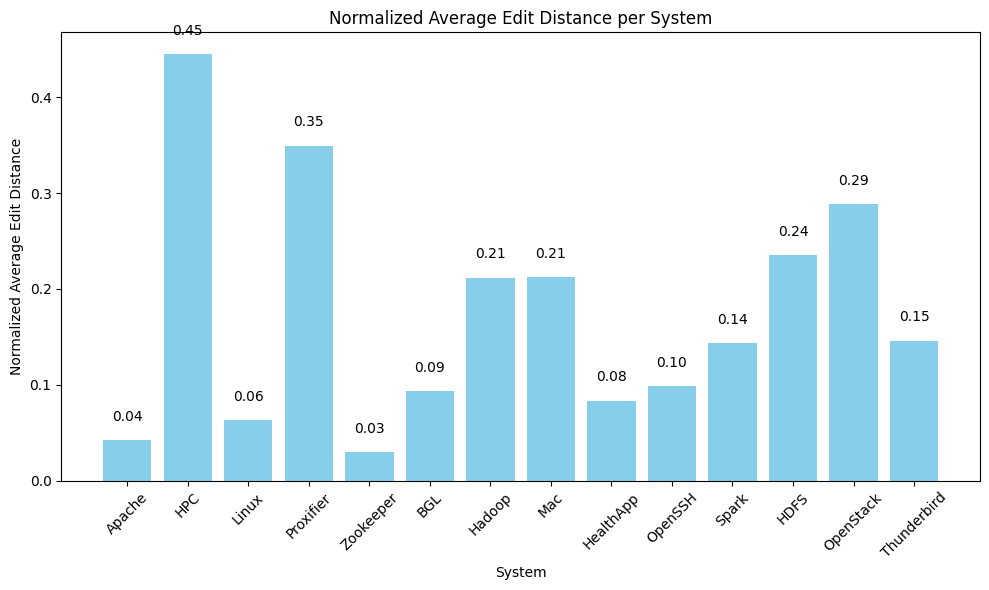

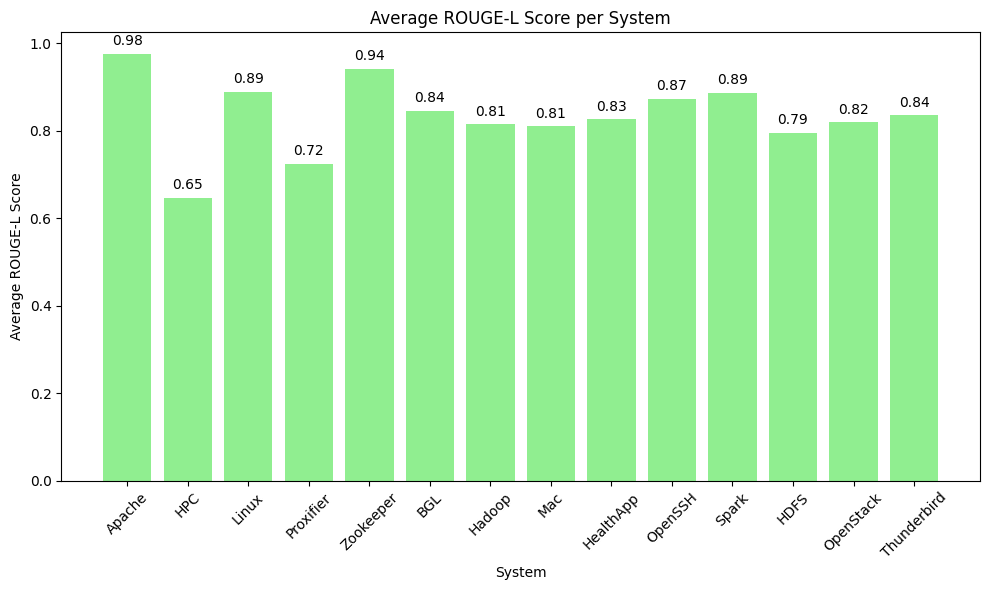

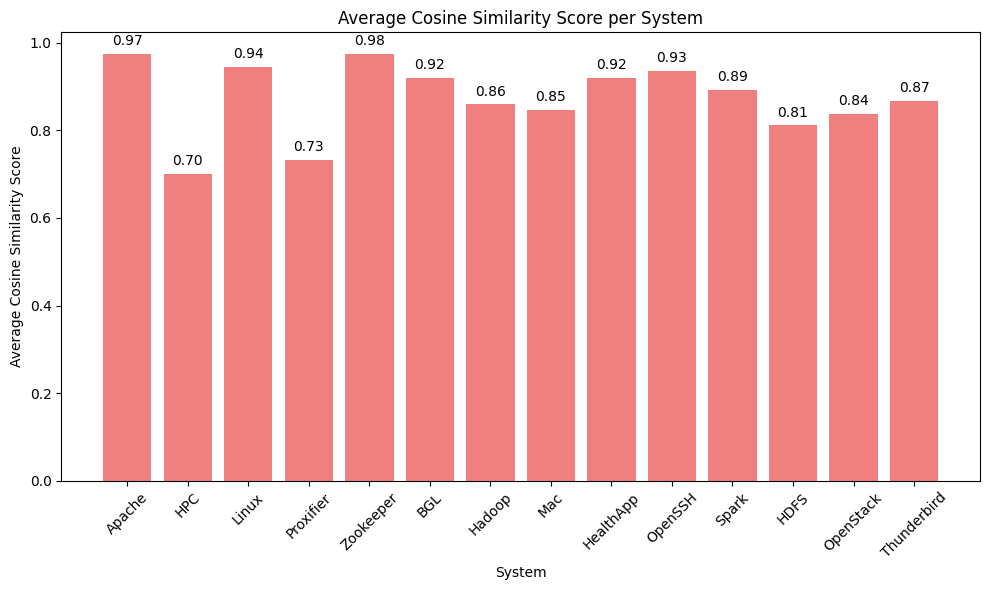

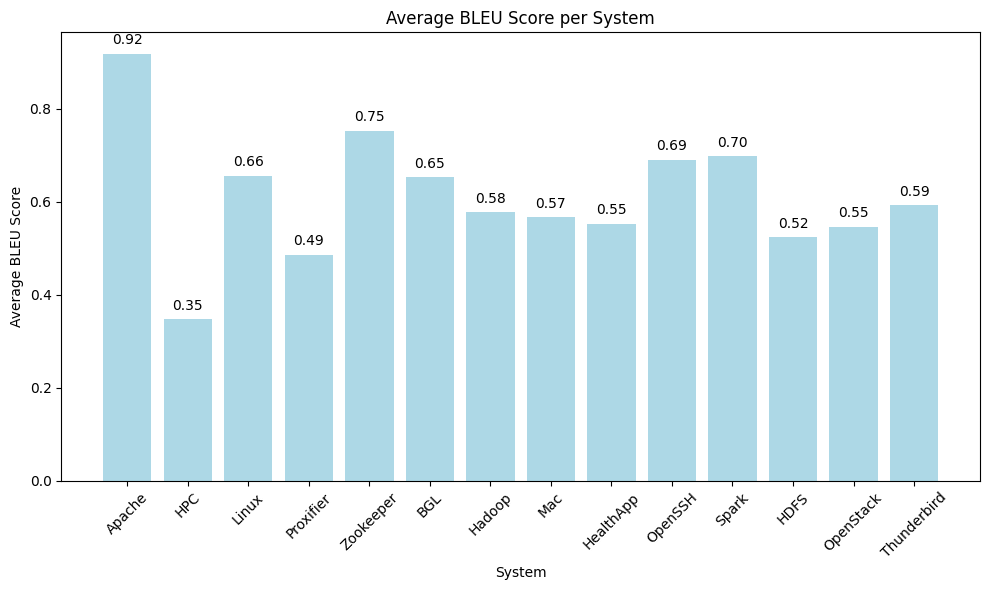

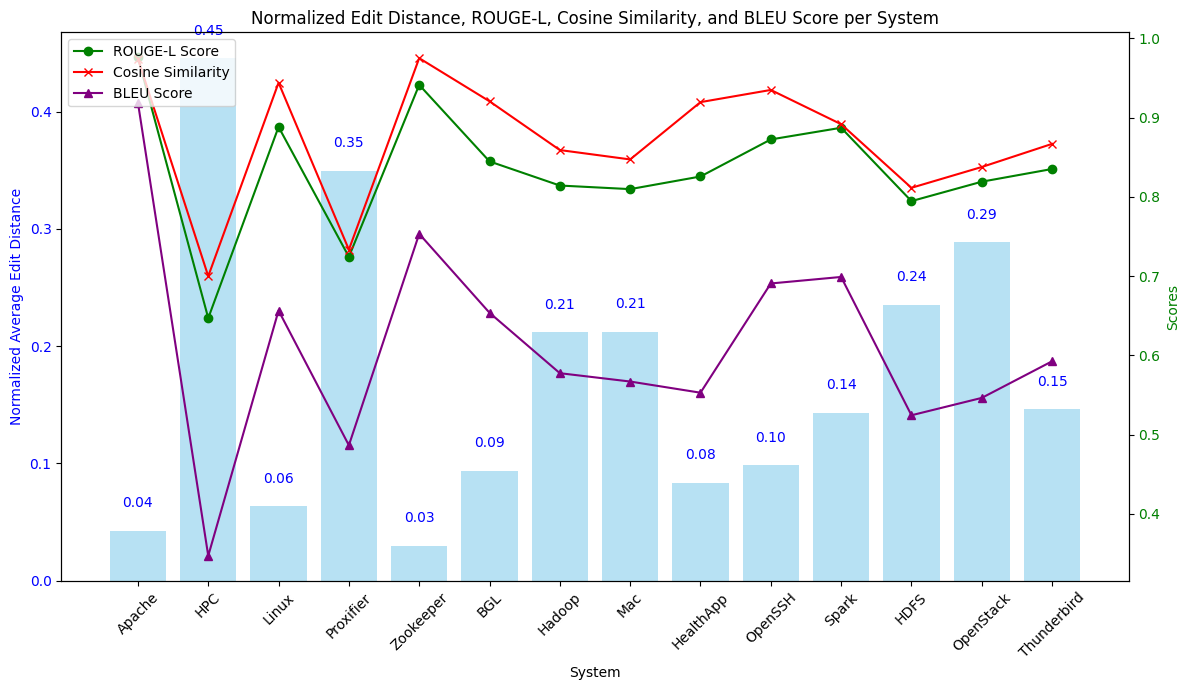

In [9]:
# 5. Visualizations

def create_visualizations(edit_distances, rouge_l_scores, cosine_similarity_scores, bleu_scores, output_directory):
    systems = list(edit_distances.keys())
    edit_values = list(edit_distances.values())
    rouge_values = list(rouge_l_scores.values())
    cosine_values = list(cosine_similarity_scores.values())
    bleu_values = list(bleu_scores.values())

    # Edit Distance Bar Plot
    plt.figure(figsize=(10, 6))
    plt.bar(systems, edit_values, color='skyblue')
    plt.xlabel('System')
    plt.ylabel('Normalized Average Edit Distance')
    plt.title('Normalized Average Edit Distance per System')
    plt.xticks(rotation=45)
    for i, value in enumerate(edit_values):
        plt.text(i, value + 0.02, f'{value:.2f}', ha='center')
    plt.tight_layout()
    plt.savefig(os.path.join(output_directory, 'edit_distance_per_system.png'))
    plt.show()
    plt.close()

    # ROUGE-L Score Bar Plot
    plt.figure(figsize=(10, 6))
    plt.bar(systems, rouge_values, color='lightgreen')
    plt.xlabel('System')
    plt.ylabel('Average ROUGE-L Score')
    plt.title('Average ROUGE-L Score per System')
    plt.xticks(rotation=45)
    for i, value in enumerate(rouge_values):
        plt.text(i, value + 0.02, f'{value:.2f}', ha='center')
    plt.tight_layout()
    plt.savefig(os.path.join(output_directory, 'rouge_l_score_per_system.png'))
    plt.show()
    plt.close()

    # Cosine Similarity Bar Plot
    plt.figure(figsize=(10, 6))
    plt.bar(systems, cosine_values, color='lightcoral')
    plt.xlabel('System')
    plt.ylabel('Average Cosine Similarity Score')
    plt.title('Average Cosine Similarity Score per System')
    plt.xticks(rotation=45)
    for i, value in enumerate(cosine_values):
        plt.text(i, value + 0.02, f'{value:.2f}', ha='center')
    plt.tight_layout()
    plt.savefig(os.path.join(output_directory, 'cosine_similarity_per_system.png'))
    plt.show()
    plt.close()

    # BLEU Score Bar Plot
    plt.figure(figsize=(10, 6))
    plt.bar(systems, bleu_values, color='lightblue')
    plt.xlabel('System')
    plt.ylabel('Average BLEU Score')
    plt.title('Average BLEU Score per System')
    plt.xticks(rotation=45)
    for i, value in enumerate(bleu_values):
        plt.text(i, value + 0.02, f'{value:.2f}', ha='center')
    plt.tight_layout()
    plt.savefig(os.path.join(output_directory, 'bleu_score_per_system.png'))
    plt.show()
    plt.close()

    # Combined Metrics Bar Plot
    fig, ax1 = plt.subplots(figsize=(12, 7))
    ax1.bar(systems, edit_values, color='skyblue', alpha=0.6, label='Edit Distance')
    ax1.set_xlabel('System')
    ax1.set_ylabel('Normalized Average Edit Distance', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    plt.xticks(rotation=45)
    for i, value in enumerate(edit_values):
        ax1.text(i, value + 0.02, f'{value:.2f}', ha='center', color='blue')
    
    ax2 = ax1.twinx()
    ax2.plot(systems, rouge_values, color='green', marker='o', linestyle='-', label='ROUGE-L Score')
    ax2.plot(systems, cosine_values, color='red', marker='x', linestyle='-', label='Cosine Similarity')
    ax2.plot(systems, bleu_values, color='purple', marker='^', linestyle='-', label='BLEU Score')
    ax2.set_ylabel('Scores', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    plt.title('Normalized Edit Distance, ROUGE-L, Cosine Similarity, and BLEU Score per System')
    fig.tight_layout()
    plt.xticks(rotation=45)
    plt.legend(loc='upper left')
    plt.savefig(os.path.join(output_directory, 'combined_scores_per_system.png'))
    plt.show()
    plt.close()

# Create and save visualizations
create_visualizations(edit_distances, rouge_l_scores, cosine_similarity_scores, bleu_scores, output_directory)


In [12]:
evaluation_metrices_results = 'gpt-syntax-combined_evaluation-log_templates_results.csv'
evaluation_metrices_results_file_path = os.path.join(save_dir_path, evaluation_metrices_results)

# Storing results into a CSV file
all_results = []

# Add Syntactic results
for system in ground_truth_systems:
    all_results.append({
        "Parsing Technique": "Syntactic",
        "LLM Model": "gpt3.5-turbo",
        "System": system,
        "Edit Distance": edit_distances.get(system, None),
        "ROUGE-L": rouge_l_scores.get(system, None),
        "Cosine Similarity": cosine_similarity_scores.get(system, None),
        "BLEU": bleu_scores.get(system, None),
    })

# Convert results to a DataFrame and save to CSV
df_results = pd.DataFrame(all_results)
df_results.to_csv(evaluation_metrices_results_file_path, index=False)

print(f"Evaluation metrics saved to {evaluation_metrices_results_file_path}")


Evaluation metrics saved to /Users/navneetsharma/Documents/NMBU/MS Data Science @ NMBU/Master's Thesis/semantic_log_parsing/results/gpt-syntax-combined_evaluation-log_templates_results.csv
